# Demographic Impact on Dental Clinic Satisfaction

This notebook presents a comprehensive study on the impact of local demographic characteristics on the customer satisfaction level of dental clinics.

Through an in-depth analysis incorporating variables such as median income, average distance to competitor clinics, population demographics, insurance coverage rates, and average age, I aim to uncover the intricate relationships between community factors and dental clinic customer satisfaction. My dataset comprises information gathered from governmental statistics, industry-specific reports, and geo-mapping techniques. The insights derived from this study are intended to guide dental service providers in making informed decisions

regarding optimal clinic placements and in tailoring their services to meet the specific needs of the local population. By analyzing these diverse variables, I hope to establish a clear understanding of the demographic drivers that influence the level of customer satisfaction in dental clinics, offering a data-driven approach to strategic service planning in the dental care industry.



In [62]:
# Basic data handling and visualization libraries
from folium.features import DivIcon
import folium
import ast
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

## Data Loading

The dataset containing competitor clinic locations is imported for analysis.

In [63]:
competitor_df = pd.read_csv("competitor_info.csv")

## Data Preprocessing

Preprocessing is crucial to prepare the scraped data for analysis. I will convert string data to numerical values, clean the dataset, and prepare it for the classification algorithms.

## Converting String Data to Numerical

String data in the reviews_count and rating columns will be converted to float.

In [64]:
# Function to convert strings to float
def convert_to_float(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

# Apply the conversion function to the `reviews_count` and `rating` columns
competitor_df['reviews_count'] = competitor_df['reviews_count'].apply(lambda x: convert_to_float(x))
competitor_df['rating'] = competitor_df['rating'].apply(lambda x: convert_to_float(x))


## Labeling Clinics Based on Reviews and Ratings

In [65]:
competitor_df['label'] = 0
for i in range(len(competitor_df)):
    if competitor_df['reviews_count'].iloc[i] > 10 and competitor_df['rating'].iloc[i] > 3.7:
        competitor_df['label'].iloc[i] = 1

## Feature Engineering

Here I will create new features that may help improve the model's predictions, such as the distance from central locations or encoding categorical variables.

## Parsing Location Data

I'll convert the location data from strings to a tuple of floats representing latitude and longitude.

In [66]:
# Convert 'lat_long' column to list of tuples
dist_list = []
for loc in competitor_df['lat_long'].tolist():
    # Clean and split the string
    x, y = loc.replace('(', '').replace(')', '').split(',')
    # Convert to float and append to list
    res = tuple(map(float, (x, y)))
    dist_list.append(res)

## Median Income Mapping to Competitor Data

This section focuses on mapping the median income data to our `competitor_df` DataFrame. I'll use the `median_income_dict` to find the median income for each census tract listed in `competitor_df`. If a census tract in our dataset isn't present in the dictionary, I'll use the mean median income calculated from the dictionary as a default value. This approach ensures every entry in our dataset has a median income value associated with it, improving the robustness of subsequent analyses.


Median income data based on census tract was retrieved from the US goverment census 

From this website:

https://data.census.gov/table?q=median&t=Income+(Households,+Families,+Individuals)&g=0100000US$310000_1400000US25017368300&y=2010&d=ACS+5-Year+Estimates+Detailed+Tables&tid=ACSDT5Y2010.B19113

In [67]:
# Load the median income dataset
income_df = pd.read_csv("Median_income.csv")

# Transpose the dataframe to make each tract and its income a separate row
median_income_transposed = income_df.transpose().reset_index()

# Rename the columns appropriately
median_income_transposed.columns = ['Tract_Info', 'Income']

# Filter out rows that contain the 'Estimate' keyword and exclude margin of error
median_income_transposed = median_income_transposed[median_income_transposed['Tract_Info'].str.contains(
    'Estimate')]

# Extract the census tract number from the 'Tract_Info' and convert income to float
median_income_transposed['Census_Tract'] = median_income_transposed['Tract_Info'].str.extract(
    r'Census Tract (\d+.\d+|\d+)', expand=False).astype(float)
median_income_transposed['Income'] = median_income_transposed['Income'].str.replace(
    ',', '').astype(float)

# Create a dictionary from the transposed dataframe
median_income_dict = pd.Series(median_income_transposed.Income.values,
                               index=median_income_transposed.Census_Tract).to_dict()

# Assuming 'competitor_df2' is the dataframe where I want to add the median income
# First, I will create a 'Median_Income' column with default value as mean median income
mean_median_income = median_income_transposed['Income'].mean()
competitor_df['Median_Income'] = competitor_df['Census_Tract'].map(
    median_income_dict).fillna(mean_median_income)

# Filter out clinics not located in Waltham district
competitor_df = competitor_df[competitor_df['location'].str.contains(
    "Waltham", na=False)]

## Analysis of Median Income Impact

After successfully associating each entry in `competitor_df` with a median income value, I can now proceed to analyze how these income levels might be affecting customer satisfaction or profitability of dental clinics. This analysis can include statistical tests, data visualizations, or any other method that can help uncover trends or patterns in the data.


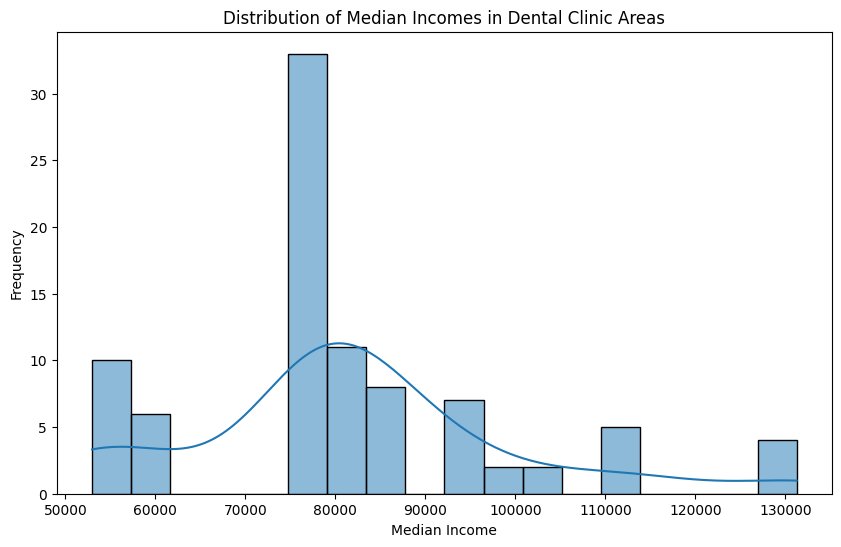

In [68]:
# Example of a simple analysis - replace with your specific analysis methods

# Importing necessary libraries for analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the distribution of median incomes
plt.figure(figsize=(10, 6))
sns.histplot(competitor_df['Median_Income'], kde=True)
plt.title('Distribution of Median Incomes in Dental Clinic Areas')
plt.xlabel('Median Income')
plt.ylabel('Frequency')
plt.show()

# You can add more analysis here, like correlation analysis, regression models, etc.

## Preparing Population Center Dataframe

In this section, I constructed a DataFrame named `center_df` based on key population centers within the Waltham district. The DataFrame will include the address, census tract, population count, geographical coordinates (latitude and longitude), and average distance to relevant points (to be added later) for each center. This data is crucial for our analysis as it forms the basis for applying machine learning classifiers later on. The goal is to understand and predict factors influencing the success of dental clinics in these population centers.

In [69]:
center_add = ["441 Lincoln Street, Waltham, MA 02451", "320 Prospect Hill Road, Waltham, MA 02451", "23 Illington Street, Waltham, MA 02451",
              "324 Bishops Forest Drive, Waltham, MA 02452", "College Drive, Waltham, MA 02452", "271 Waverley Oaks Road, Waltham, MA 02452"]
center_tract = [3681.02, 3682.00, 3683.00, 3689.02, 3690.00, 3691.00]
center_pop = [4718, 4198, 5763, 3691, 3300, 5059]
center_lat_long = [(42.402936, -71.248190), (42.384458, -71.252627), (42.377161, -71.248068),
                   (42.379787, -71.230603), (42.386681, -71.221165), (42.383564, -71.206967)]

# Create the DataFrame
d = {"Address": center_add, "Census_Tract": center_tract,
     "Population": center_pop, "Lat_Long": center_lat_long}
center_df = pd.DataFrame(data=d, index=["A", "B", "C", "D", "E", "F"])

## Integrating Median Income Data

With `center_df` established, the next step is to integrate median income data for each population center. I utilize the `diction` dictionary, which maps census tracts to their respective median incomes. For centers where median income data is unavailable, I assign 'Na' to indicate this. The enhanced dataset, now including median incomes, will offer a more comprehensive view for our machine learning applications, allowing us to assess the impact of economic factors on clinic success.


In [70]:
# Calculate the mean median income
mean_median_income = sum(median_income_dict.values()) / len(median_income_dict)

# Add median income to each center
income_lst = []
for k in center_df["Census_Tract"]:
    if k in median_income_dict:
        income_lst.append(median_income_dict[k])
    else:
        # Use the mean median income if the census tract doesn't match
        income_lst.append(mean_median_income)

# Add the income list to the center_df DataFrame
center_df["Median_Income"] = income_lst

# Save the updated DataFrame to a new CSV file
center_df.to_csv("center_data2.csv", index=False)


## Removing Outliers to Enhance Model Reliability

After identifying outliers in the dataset, the next step is to preprocess the data to improve the accuracy of our machine learning models. This involves cleaning the data by removing outliers, particularly those identified in the average distance variable.

In [71]:
# Calculate the upper bound for outliers in average distance
q3, q1 = np.percentile(competitor_df['avg_distance'], [75, 25])
IQR = q3 - q1
upper_bound = q3 + (1.5 * IQR)

# Remove outliers from the dataset
# Rows where the average distance is greater than the upper bound are considered outliers and removed
competitor_df_cleaned = competitor_df[competitor_df['avg_distance'] < upper_bound]

# Display the first few rows of the cleaned DataFrame
competitor_df_cleaned.head()

,name,rating,reviews_count,location,exception,Population,Census_Tract,lat_long,Label,avg_distance,Median_Income,label
0,Waltham Family Dental,4.7,244.0,"30 Grant St, Waltham, MA 02453",NaN,5763,3683.0,"(42.37568533333334, -71.24194583333333)",1.0,7.475701,78088.0,1
1,Gentle Dental Waltham,4.7,222.0,"879 Main St, Waltham, MA 02451",NaN,5763,3683.0,"(42.3761905, -71.24637778571429)",1.0,7.594937,78088.0,1
2,Advanced Waltham Dental,4.9,27.0,"100 Maple St, Waltham, MA 02453",NaN,3419,3685.0,"(42.367719430732016, -71.23795462304705)",1.0,7.529118,52976.0,1
4,The Flossery - Functional Dentistry,4.9,124.0,"32 South St, Waltham, MA 02453",NaN,5763,3683.0,"(42.374640368421055, -71.24993452631578)",1.0,7.713242,78088.0,1
6,"376 Dental Studio: Poonam Soi, DMD",4.9,93.0,"376 Moody St, Waltham, MA 02453",NaN,3419,3685.0,"(42.36982610526316, -71.23704605263158)",1.0,7.443476,52976.0,1


## Verifying Data Post-Preprocessing

Post preprocessing, it's important to verify the state of the data. This includes checking the dimensions of the dataset to ensure outliers have been successfully removed and visually inspecting the data, perhaps with a plot, to confirm that the distribution of the 'average distance' variable now aligns more closely with our expectations for a typical dataset.


Shape of DataFrame after removing outliers: (70, 12)


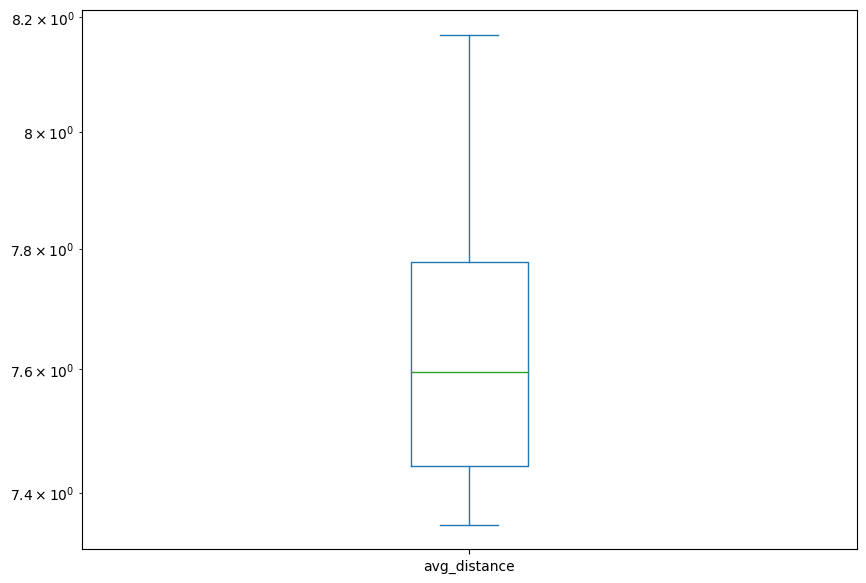

In [72]:
# Display the shape of the cleaned DataFrame
print("Shape of DataFrame after removing outliers:", competitor_df_cleaned.shape)

# Optionally, plot a boxplot again to visualize the 'average distance' distribution after removing outliers
competitor_df_cleaned['avg_distance'].plot(kind='box', figsize=(10, 7))
plt.semilogy()  # Use a logarithmic scale for better visualization
plt.show()

## Exploratory Data Analysis (EDA)

In this section, I perform an exploratory data analysis (EDA) to understand the relationships betIen various variables and their impact on dental clinic labels. I focus on three main variables: median income, population, and average distance. Our goal is to visualize these variables' distribution and correlation with the labels to gain insights that could guide our machine learning model development.


### Correlation Heatmap

First, I generate a heatmap to visualize the correlation between different variables. This helps in identifying which features are most strongly associated with the labels.


In [73]:
# Import necessary libraries
import pandas as pd
import plotly.express as px

# Assuming competitor_df is your DataFrame
# Select only numeric columns for correlation
numeric_df = competitor_df.select_dtypes(include=[np.number])

# Generate a correlation matrix from the numeric DataFrame
corr_matrix = numeric_df.corr()
# Round the numbers in the correlation matrix to 2 decimal places
corr_matrix = corr_matrix.round(3)

# Create a heatmap using Plotly
fig = px.imshow(corr_matrix, text_auto=True, aspect="auto",
                color_continuous_scale="RdBu_r", title="Correlation Heatmap")
fig.show()

### Grouped Bar Chart Visualization

Next, we visualize the average values of population, median income, and average distance for each label (1 and 0) to observe how these variables differ between the two groups.


In [74]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

# Select only numeric columns for aggregation
numeric_cols = competitor_df.select_dtypes(include=[np.number])

# Group data by label and calculate mean for numeric columns only
label_group = numeric_cols.groupby(competitor_df["Label"]).mean()

# Create subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=(
    "Population", "Median Income", "Average Distance", "Average Rating"))

# Check if the columns exist in label_group before adding traces
if "Population" in label_group.columns:
    fig.add_trace(go.Bar(x=label_group.index,
                  y=label_group["Population"], name='Population'), row=1, col=1)
if "Median_Income" in label_group.columns:
    fig.add_trace(go.Bar(x=label_group.index,
                  y=label_group["Median_Income"], name='Median Income', marker_color='orange'), row=1, col=2)
if "avg_distance" in label_group.columns:
    fig.add_trace(go.Bar(x=label_group.index,
                  y=label_group["avg_distance"], name='Average Distance', marker_color='green'), row=2, col=1)
if "rating" in label_group.columns:
    fig.add_trace(go.Bar(x=label_group.index,
                  y=label_group["rating"], name='Average Rating', marker_color='red'), row=2, col=2)

# Update layout
fig.update_layout(height=700, width=800,
                  title_text="Average Values Grouped by Label")
fig.show()

### Scatter Plot Analysis

Finally, I created scatter plots to visualize the relationship between average distance and median income for clinics labeled as 1 (positive) and 0 (negative).


In [75]:
# Separate the data based on labels
pos = competitor_df[competitor_df["Label"] == 1]
neg = competitor_df[competitor_df["Label"] == 0]

# Create scatter plot
fig = px.scatter(pos, x="avg_distance", y="Median_Income", color_discrete_sequence=[
                 'blue'], labels={'x': 'Average Distance', 'y': 'Median Income'})
fig.add_scatter(x=neg["avg_distance"], y=neg["Median_Income"],
                mode='markers', marker=dict(color='red'), name='Label: 0')
fig.update_layout(
    title="Scatter Plot of Median Income vs. Average Distance", legend_title="Labels")
fig.show()

## Applying Machine Learning Classifiers

In this section, we apply various machine learning classifiers to predict the labels of dental clinics based on the key variables: median income, population, and average distance. We will use Logistic Regression, Naive Bayes, and different kernels of Support Vector Machines (SVMs) to evaluate their performance in predicting customer satisfaction levels.


### Logistic Regression Classifier

Firstly, I implement a Logistic Regression model. This classifier is used to estimate discrete values (binary values like 0/1) from a set of independent variables.


In [76]:
# Implement logistic regression classifier
X = competitor_df[["avg_distance", "Median_Income", "Population"]].values
y = competitor_df["Label"]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state=24)
logreg = LogisticRegression(solver='lbfgs', random_state=24)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Accuracy for logistic regression:",round(accuracy_score(y_test, y_pred),2))

Accuracy for logistic regression: 0.7


### ROC AUC Curve for Logistic Regression

To evaluate the performance of the logistic regression model, I plot the ROC AUC curve. This curve is a performance measurement for classification problems.


In [77]:
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_test, y_pred)

fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines',
              name='ROC curve (area = %0.2f)' % roc_auc))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
              mode='lines', line=dict(dash='dash'), name='Random'))
fig.update_layout(title='ROC Curve for Logistic Regression',
                  xaxis_title='False Positive Rate', yaxis_title='True Positive Rate')

fig.show()

### Naive Bayes Classifier

Next, we implement the Naive Bayes classifier, a simple yet effective probabilistic classifier.


In [78]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Accuracy for Naive Bayes:", round(accuracy_score(y_test, y_pred_nb), 2))

Accuracy for Naive Bayes: 0.74


### Support Vector Machine (SVM) Classifier

I then use the SVM classifier with different kernels. SVMs are known for their ability to handle high-dimensional data and are effective in cases where the number of dimensions is greater than the number of samples.


In [79]:
# SVM with a linear kernel
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.3, random_state=27)
model_linear = SVC(kernel="linear")
model_linear.fit(X_train, y_train)
y_pred_svm_linear = model_linear.predict(X_test)

print("Accuracy for SVM Linear Kernel:", round(
    accuracy_score(y_test, y_pred_svm_linear), 2))

Accuracy for SVM Linear Kernel: 0.81


#### Applying Logistic Regression to Predict Labels

In this segment of the analysis, I apply Logistic Regression to predict the satisfaction labels for dental clinics. Logistic Regression is a robust method for binary classification tasks like this one, where the objective is to categorize clinics based on factors such as average distance, median income, and population size.

In [80]:
# Assuming competitor_df2 is your DataFrame and it's already preprocessed
X = competitor_df[["avg_distance", "Median_Income", "Population"]].values
y = competitor_df["Label"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=24)

# Train the Logistic Regression model
logreg = LogisticRegression(solver='lbfgs', random_state=24)
logreg.fit(X_train, y_train)

# Predict labels for the test set
y_pred = logreg.predict(X_test)

# Print the accuracy
accuracy = round(accuracy_score(y_test, y_pred), 2)
print("Accuracy:", accuracy)

# Create a DataFrame to display actual and predicted labels
results_df = pd.DataFrame({'Actual Label': y_test, 'Predicted Label': y_pred})
print(results_df)

Accuracy: 0.7
     Actual Label  Predicted Label
122           1.0              0.0
112           0.0              0.0
20            1.0              0.0
13            1.0              0.0
48            0.0              0.0
43            0.0              0.0
76            1.0              0.0
63            1.0              0.0
115           0.0              0.0
26            0.0              0.0
91            0.0              0.0
39            0.0              0.0
14            0.0              0.0
120           1.0              0.0
44            0.0              0.0
24            0.0              0.0
51            0.0              0.0
37            0.0              0.0
16            1.0              0.0
98            0.0              0.0
23            0.0              0.0
38            0.0              0.0
50            0.0              0.0
9             1.0              0.0
73            0.0              0.0
29            0.0              0.0
8             0.0              0.0


## Generating Interactive Map Based on Logistic Regression Results

This section focuses on creating an interactive map to visualize the results of our logistic regression model. The map will display the locations of dental clinics, with markers colored based on the predicted labels from our logistic regression model. Red markers indicate clinics predicted to have higher satisfaction levels, while blue markers represent clinics with lower predicted satisfaction.


In [81]:
import pandas as pd
import folium
import ast


# Load your dataframes
# Replace with your actual file path
center_df = pd.read_csv('center_data2.csv')
# Replace with your actual file path
competitor_df = pd.read_csv('competitor_info.csv')

# Function to generate popup content
def gen_popup(df, index):
    address_col = "Address" if "Address" in df.columns else "location"
    html = f"""Address: {df[address_col].iloc[index]}<br>
               Census tract: {df["Census_Tract"].iloc[index]}<br>
               Population: {df["Population"].iloc[index]}<br>
               Median Income: {df["Median_Income"].iloc[index]}"""
    return html

# Function to create a numbered marker


def number_DivIcon(number, color):
    icon = folium.DivIcon(
        icon_size=(150, 36),
        icon_anchor=(14, 40),
        html=f"""<span class="fa-stack" style="font-size: 12pt">
                    <span class="fa fa-circle-o fa-stack-2x" style="color: {color}"></span>
                    <strong class="fa-stack-1x">{number}</strong>
                </span>"""
    )
    return icon


# Initialize the map
m = folium.Map(location=[42.38724610222085, -71.23371985565409], zoom_start=12)

# Add markers for each center
for index, row in center_df.iterrows():
    loc = ast.literal_eval(row["Lat_Long"]) if isinstance(
        row["Lat_Long"], str) else row["Lat_Long"]
    popup_html = gen_popup(center_df, index)
    folium.Marker(
        location=loc,
        popup=folium.Popup(popup_html, max_width=2650),
        icon=number_DivIcon(index + 1, '#5d8aa8')
    ).add_to(m)

# Add markers for competitor clinics
for index, row in competitor_df.iterrows():
    try:
        loc = ast.literal_eval(row["lat_long"]) if isinstance(
            row["lat_long"], str) else row["lat_long"]
        popup_html = gen_popup(competitor_df, index)
        marker_color = 'blue' if row["Label"] == 1 else 'red'
        folium.Marker(
            location=loc,
            popup=folium.Popup(popup_html, max_width=2650),
            icon=folium.Icon(color=marker_color, icon_color='white')
        ).add_to(m)
    except Exception as e:
        print(f"Error adding marker for row {index}: {e}")

# Save the map to an HTML file
# m.save("map.html")
        
# Display the map
m